#Paquetes necesarios

Podremos hacer uso del mismo *environment* de la primera práctica, aunque en ocasiones pedirá instalar Pillow

In [ ]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

Carga imagen desde archivo y convierte a RGB

TAREA: Realiza la cuenta de píxeles blancos por filas (en lugar de por columnas). Determina el valor máximo de píxeles blancos para filas, maxfil, mostrando el número de filas y sus respectivas posiciones, con un número de píxeles blancos mayor o igual que 0.90*maxfil.

(0.0, 512.0)

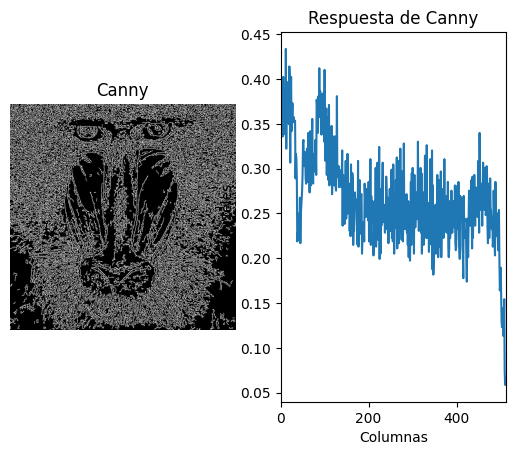

In [8]:
img = cv2.imread('mandril.jpg') 

canny = cv2.Canny(img, 100, 200)
#El contenido de la imagen resultado de Canny, son valores 0 o 255, lo compruebas al descomentar
#print(canny)
#Cuenta el número de píxeles blancos (255) por columna
#Suma los valores de los pixeles por columna
col_counts = cv2.reduce(canny, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)

#Normaliza en base al número de filas, primer valor devuelto por shape, y al valor máximo del píxel (255)
#El resultado será el número de píxeles blancos por columna
rows = col_counts[:,] / (255 * canny.shape[0])
cols = row_counts[:,] / (255 * canny.shape[1])

#Muestra dicha cuenta gráficamente
plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray') 

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
#Rango en x definido por las columnas
plt.xlim([0, canny.shape[0]])

TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

Filas destacadas: [121]


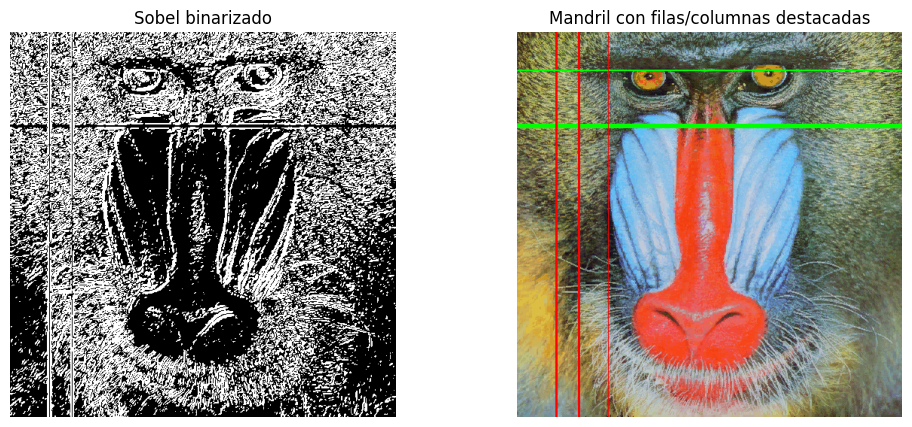

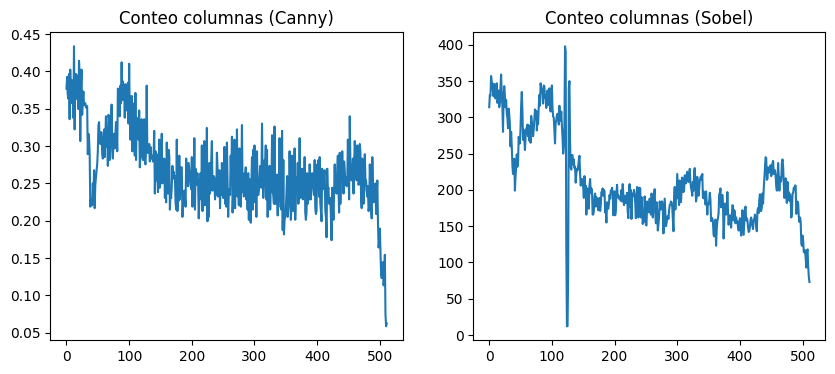

In [7]:
# Aplica Sobel y umbralizado
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ggris = cv2.GaussianBlur(gris, (3, 3), 0)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)
sobel = cv2.add(sobelx, sobely)
sobel_8u = cv2.convertScaleAbs(sobel)
_, sobel_bin = cv2.threshold(sobel_8u, 50, 255, cv2.THRESH_BINARY)

# Conteo por filas y columnas
row_counts_sobel = np.count_nonzero(sobel_bin, axis=1)
col_counts_sobel = np.count_nonzero(sobel_bin, axis=0)

# Máximos y umbral del 90%
max_rows = np.max(row_counts_sobel)
max_cols = np.max(col_counts_sobel)
umbral_rows = 0.98 * max_rows
umbral_cols = 0.98 * max_cols

# Filas y columnas destacadas
filas_destacadas = np.where(row_counts_sobel >= umbral_rows)[0]
columnas_destacadas = np.where(col_counts_sobel >= umbral_cols)[0]

# Remarca filas y columnas sobre la imagen original
img_marcada = img.copy()
for row in columnas_destacadas:
    cv2.line(img_marcada, (0, row), (img.shape[1]-1, row), (0,255,0), 1)
for col in filas_destacadas:
    cv2.line(img_marcada, (col, 0), (col, img.shape[0]-1), (0,0,255), 1)

print(f"Filas destacadas: {filas_destacadas}")
# Visualización
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Sobel binarizado")
plt.axis("off")
plt.imshow(sobel_bin, cmap='gray')
plt.subplot(1,2,2)
plt.title("Mandril con filas/columnas destacadas")
plt.axis("off")
plt.imshow(cv2.cvtColor(img_marcada, cv2.COLOR_BGR2RGB))
plt.show()

# Comparación con Canny
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Conteo columnas (Canny)")
plt.plot(cols)
plt.subplot(1,2,2)
plt.title("Conteo columnas (Sobel)")
plt.plot(row_counts_sobel)
plt.show()


TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.


In [6]:
import cv2 as cv
import numpy as np
from collections import deque

def draw_overlay(img, mode, hint=""):
    out = img.copy()
    txt = f"Modo: {mode} | [M] sig. | [0-4] ir | [ESC] salir"
    if hint:
        txt += f" | {hint}"
    cv.rectangle(out, (0, 0), (out.shape[1], 30), (0, 0, 0), -1)
    cv.putText(out, txt, (10, 22), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv.LINE_AA)
    return out

def gray_convett(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def mode_gray_equalize(img):
    gray_image = gray_convett(img)
    equalize = cv.equalizeHist(gray_image)                        
    return cv.cvtColor(equalize, cv.COLOR_GRAY2BGR)               

def canny_mode(img):
    gray = cv.GaussianBlur(gray_convett(img), (5, 5), 0)        
    edges = cv.Canny(gray, 100, 200)
    return cv.cvtColor(edges, cv.COLOR_GRAY2BGR)

def cartoon_mode(img):
    gray = gray_convett(img)
    gray = cv.medianBlur(gray, 5)
    edges = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C,
                                 cv.THRESH_BINARY, 11, 4)
    color = cv.bilateralFilter(img, 9, 250, 250)
    cartoon = cv.bitwise_and(color, color, mask=edges)
    return cartoon

def alpha_blend_uniform(base_bgr, color_bgr, alpha):
    solid = np.full_like(base_bgr, color_bgr, dtype=np.uint8)
    return cv.addWeighted(base_bgr, 1.0 - alpha, solid, alpha, 0.0)

def neon_line(img):
    gray_img = cv.GaussianBlur( gray_convett(img), (5, 5), 0)
    edges = cv.Canny(gray_img, 100, 200)
    halo =  cv.dilate(edges, np.ones ((7,7), np.uint8),1)
    halo = cv.GaussianBlur(halo, (7,7), 0)
    alpha = cv.normalize(halo, None, 0, 1.0, cv.NORM_MINMAX, cv.CV_32F)
    color= np.zeros_like(img, dtype=np.uint8)
    color[:] = (255,0,255)
    neon = (alpha[..., None] * color).astype(np.uint8)
    out = cv.addWeighted(img, 0.65, neon, 0.80, 0.0)
    return out
    

COLORS = {
    "R": (0,   0, 255),
    "G": (0, 255,   0),
    "B": (255, 0,   0),
    "Y": (0, 255, 255),
    "C": (255,255,  0),
    "M": (255, 0, 255),
    "W": (255,255,255),
    "K": (0,   0,   0),
}

def mode_uniform_tint(img, tint_key, alpha, view_mode=0):
    tinted = alpha_blend_uniform(img, COLORS[tint_key], alpha)
    hint = f"tinte={tint_key} alpha={alpha:.2f} view={'comp' if view_mode==0 else 'res'}"
    if view_mode == 0:
        side = np.hstack([img, tinted])
        if side.shape[1] > 1280:
            side = cv.resize(side, (1280, int(1280*side.shape[0]/side.shape[1])))
        return side, hint
    else:
        return tinted, hint

if __name__ == "__main__":
    mode = 0 
    tint_key = "B"   
    alpha = 0.45
    view_mode = 0  

    capture = cv.VideoCapture(0)
    w = int(capture.get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(capture.get(cv.CAP_PROP_FRAME_HEIGHT))
    if not capture.isOpened():
        print("Cannot open camera")
        exit()

    while True:
        ret, frame = capture.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break

        hint = ""
        if mode == 0:
            output = frame
        elif mode == 1:
            output = mode_gray_equalize(frame)
        elif mode == 2:
            output = canny_mode(frame)
        elif mode == 3:
            output = cartoon_mode(frame)
        elif mode == 4:
            output, hint = mode_uniform_tint(frame, tint_key, alpha, view_mode)
        elif mode == 5:
            output = neon_line(frame)
        else:
            output = frame

        output = draw_overlay(output, mode, hint)
        cv.imshow('frame', output)

        key = cv.waitKey(20) & 0xFF
        if key == 27:                      
            break
        elif key in (ord('m'), ord('M')):    
            mode = (mode + 1) % 6
        elif key in (ord('0'), ord('1'), ord('2'), ord('3'), ord('4')):
            mode = int(chr(key))

        if mode == 4:
            if key in map(ord, list("RGBYCMWKrgbycmwk")):
                tint_key = chr(key).upper()
            elif key in (ord('+'), ord('=')):
                alpha = min(1.0, alpha + 0.05)
            elif key in (ord('-'), ord('_')):
                alpha = max(0.0, alpha - 0.05)
            elif key in (ord('v'), ord('V')):
                view_mode = 1 - view_mode

    capture.release()
    cv.destroyAllWindows()


TAREA: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [ ]:
import cv2 as cv
import numpy as np

def draw_header_bar(img, text):
    out = img.copy()
    cv.rectangle(out, (0, 0), (out.shape[1], 30), (0, 0, 0), -1)
    cv.putText(out, text, (10, 22), cv.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv.LINE_AA)
    return out

def to_gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def detect_person_mask(gray, bg_subtractor, kernel):
    blurred = cv.GaussianBlur(gray, (5,5), 0)
    fg = bg_subtractor.apply(blurred)
    _, mask = cv.threshold(fg, 200, 255, cv.THRESH_BINARY)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=2)
    return mask

def largest_contour_centroid(mask, min_area=10000):
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None
    areas = [cv.contourArea(c) for c in contours]
    i = int(np.argmax(areas))
    if areas[i] < min_area:
        return None, None
    cnt = contours[i]
    M = cv.moments(cnt)
    if M["m00"] == 0:
        return cnt, None
    cx = int(M["m10"]/M["m00"]); cy = int(M["m01"]/M["m00"])
    return cnt, (cx, cy)

def apply_digital_curtain(frame, center_x, window_half_width):
    h, w = frame.shape[:2]
    x = np.arange(w, dtype=np.float32)
    dist = np.abs(x - float(center_x))
    soft = 1.0 - np.clip((dist - window_half_width) / max(window_half_width, 1), 0.0, 1.0)
    soft = 0.25 + 0.75 * soft 
    mask_1d = soft.astype(np.float32)
    mask_2d = np.tile(mask_1d[None, :], (h, 1))
    masked = (frame.astype(np.float32) * mask_2d[..., None]).astype(np.uint8)
    return masked

def main():
    cap = cv.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        return

    bg = cv.createBackgroundSubtractorMOG2(history=220, varThreshold=24, detectShadows=False)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    show_mask = False
    window_half_width = 120  
    last_center_x = None

    while True:
        ok, frame = cap.read()
        if not ok:
            print("Can't receive frame. Exiting ...")
            break

        gray = to_gray(frame)
        mask = detect_person_mask(gray, bg, kernel)
        cnt, centroid = largest_contour_centroid(mask)
        h, w = frame.shape[:2]
        if centroid is not None:
            last_center_x = centroid[0]
        if last_center_x is None:
            last_center_x = w // 2

        curtain_view = apply_digital_curtain(frame, last_center_x, window_half_width)

        if show_mask:
            mask_bgr = cv.cvtColor(mask, cv.COLOR_GRAY2BGR)
            debug = frame.copy()
            if cnt is not None:
                cv.drawContours(debug, [cnt], -1, (0,255,255), 2)
                cv.circle(debug, (last_center_x, h//2), 5, (0,0,255), -1, lineType=cv.LINE_AA)
            side = np.hstack([
                frame,
                mask_bgr,
                debug,
                curtain_view
            ])
            if side.shape[1] > 1280:
                side = cv.resize(side, (1280, int(1280*side.shape[0]/side.shape[1])))
            out = draw_header_bar(side, header)
        else:
            out = curtain_view.copy()
            x0 = max(0, int(last_center_x - window_half_width))
            x1 = min(w-1, int(last_center_x + window_half_width))
            cv.rectangle(out, (x0, 0), (x1, h-1), (255,255,255), 1, cv.LINE_AA)
            header = f"Demostrador: Cortina Digital | ESC salir | A/Z +/- ancho | V ver máscara | ancho={2*window_half_width}"
            out = draw_header_bar(out, header)

        cv.imshow("cortina_digital", out)
        key = cv.waitKey(20) & 0xFF
        if key == 27:
            break
        elif key in (ord('a'), ord('A')):
            window_half_width = min(w//2, window_half_width + 10)
        elif key in (ord('z'), ord('Z')):
            window_half_width = max(20, window_half_width - 10)
        elif key in (ord('v'), ord('V')):
            show_mask = not show_mask

    cap.release()
    cv.destroyAllWindows()

if __name__ == "__main__":
    main()
